# Functions etc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import roc_auc_score, accuracy_score

# Case 1

Data: transaction_sample.csv

In [2]:
df_trx = pd.read_csv('./data/transaction_sample.csv')
print('Shape:', df_trx.shape)
df_trx.head()

Shape: (4727, 7)


,Transaction ID,Transaction Hour,Transaction Amount,Account Age Days,Is Fraudulent,y_pred,y_pred_proba
0,34bf1ce8-118a-467b-a319-9e7e02d5845c,5,79.02,216,0,0,0.114403
1,bd73ee3b-34da-4dd5-a494-1e0964045a47,22,89.29,198,0,0,0.172854
2,65db4491-943b-49f1-96f6-948b677ae953,10,1070.04,148,0,0,0.389952
3,bc3198c1-64f6-473b-bcbc-dfdfe59dc64d,21,281.05,35,0,0,0.228857
4,f3dd988b-ffc4-4d5e-95fe-e9760f1b52ab,11,69.61,271,0,0,0.357841


## 1. Introduction

Task: Determine which part of data that needs to be labeled by experts.

Hint: Identify low-confidence predictions using uncertainty sampling techniques

I set threshold of 45%, so I define low-confidence predictions are those with `y_pred_proba` between 45% and 1-45%.

In [3]:
prob_thresh = 0.45
low_conf = df_trx[(df_trx['y_pred_proba'] > prob_thresh) & (df_trx['y_pred_proba'] < 1-prob_thresh)]
print('Shape:', low_conf.shape)
low_conf.head()

Shape: (42, 7)


,Transaction ID,Transaction Hour,Transaction Amount,Account Age Days,Is Fraudulent,y_pred,y_pred_proba
164,1b5ac78e-5f68-46ef-a895-4603e271cee3,1,106.55,16,1,0,0.452965
429,7c59ac0a-fb1e-4426-8169-3917c51f3cb4,3,348.05,4,1,0,0.486965
653,7b7f02c7-eef3-40e7-a2ae-64022696cf2f,1,230.02,254,1,0,0.480162
667,11c6964f-8ca4-40c2-aadf-0cee2470b7c1,0,75.67,364,1,0,0.481831
773,a2e647ad-3fa7-4108-88fe-6edac82bc6eb,3,267.18,189,1,0,0.454464


## 2. Annotation

Assuming you are an expert, annotate the data which was previously selected.
Task:
- Perform Exploratory Data Analysis (EDA) to detect patterns and insights
from the dataset to help predicting fraud.
- Define expert rules based on EDA for annotation.
- Annotate whether fraud or non fraud on the previously selected uncertain
transactions from Question 1 based on these rules.
- Update ‘y_ped’ where some parts of data are from the newly annotated
data. Store to new columns named “y_pred_exp”.

### EDA

I will create new column: log of Transaction Amount, because I found that column to be very skewed:

<Axes: ylabel='Frequency'>

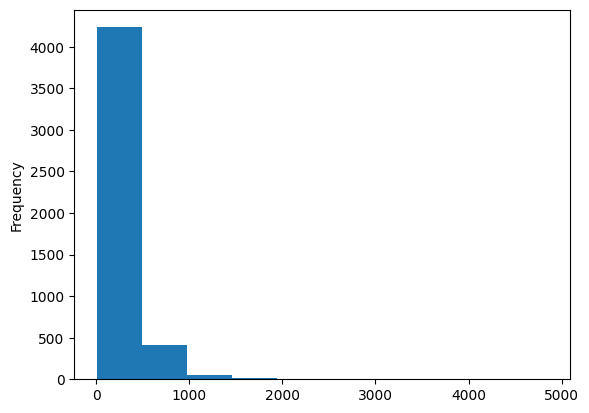

In [4]:
df_trx['Transaction Amount'].plot.hist()

In [5]:
df_trx_mod = df_trx.copy()
df_trx_mod['Log Transaction Amount'] = np.log(df_trx_mod['Transaction Amount'])

<Axes: ylabel='Frequency'>

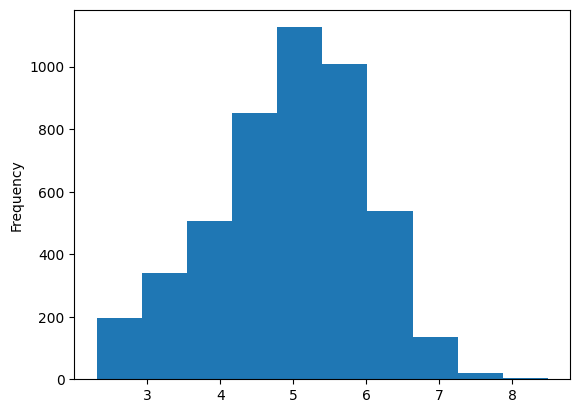

In [6]:
df_trx_mod['Log Transaction Amount'].plot.hist()

What's the probability of fraudulent transaction?

In [7]:
df_trx_mod['Is Fraudulent'].mean()

0.051829913264226785

<Axes: xlabel='Is Fraudulent', ylabel='Transaction Hour'>

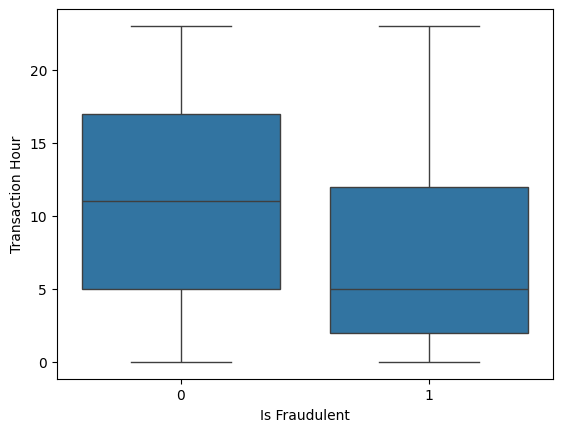

In [8]:
sns.boxplot(df_trx_mod, x='Is Fraudulent', y='Transaction Hour')

<Axes: xlabel='Is Fraudulent', ylabel='Log Transaction Amount'>

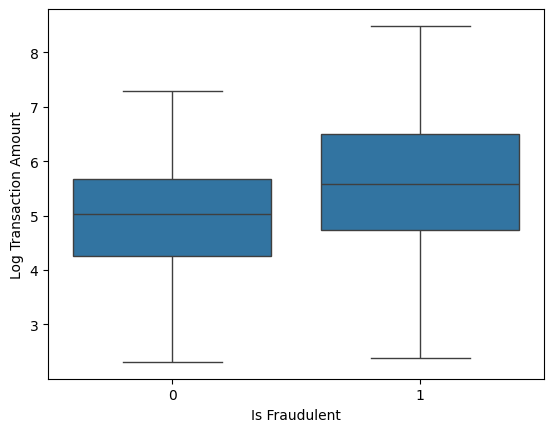

In [9]:
sns.boxplot(df_trx_mod, x='Is Fraudulent', y='Log Transaction Amount')

<Axes: xlabel='Is Fraudulent', ylabel='Account Age Days'>

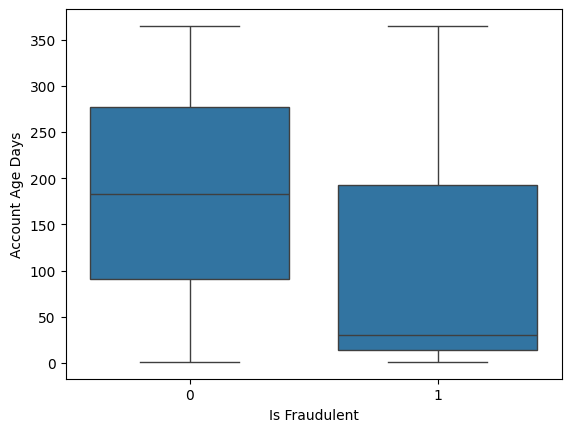

In [10]:
sns.boxplot(df_trx_mod, x='Is Fraudulent', y='Account Age Days')

In short, fraudulent transactions are more likely to have: lower Transaction Hour, lower Account Age Days, and higher Log Transaction Amount.

Below I will store the modified data for low-confidence observations:

In [11]:
low_conf_mod = df_trx_mod.loc[low_conf.index]
low_conf_mod.head()

,Transaction ID,Transaction Hour,Transaction Amount,Account Age Days,Is Fraudulent,y_pred,y_pred_proba,Log Transaction Amount
164,1b5ac78e-5f68-46ef-a895-4603e271cee3,1,106.55,16,1,0,0.452965,4.668614
429,7c59ac0a-fb1e-4426-8169-3917c51f3cb4,3,348.05,4,1,0,0.486965,5.852346
653,7b7f02c7-eef3-40e7-a2ae-64022696cf2f,1,230.02,254,1,0,0.480162,5.438166
667,11c6964f-8ca4-40c2-aadf-0cee2470b7c1,0,75.67,364,1,0,0.481831,4.326382
773,a2e647ad-3fa7-4108-88fe-6edac82bc6eb,3,267.18,189,1,0,0.454464,5.587923


### Defining the rules

Based on the box plot above, I will define fraud if the observation satisfy _any_ of the following condition:

- Transaction Hour less than the 1st quartile
- Log Transaction Amount greater than the 3rd quartile
- Account Age Days less than the 1st quartile

In [12]:
trx_hour_thresh = df_trx_mod['Transaction Hour'].quantile(0.25)
trx_amount_thresh = df_trx_mod['Log Transaction Amount'].quantile(0.75)
acc_age_thresh = df_trx_mod['Account Age Days'].quantile(0.25)

In [13]:
start_time = time.time()

low_conf_exp = ((low_conf_mod['Transaction Hour'] < trx_hour_thresh) |
                (low_conf_mod['Log Transaction Amount'] > trx_amount_thresh) |
                (low_conf_mod['Account Age Days'] < acc_age_thresh)).astype(int)

df_trx_exp = df_trx_mod.copy()
df_trx_exp['y_pred_exp'] = df_trx_exp['y_pred'].copy()
df_trx_exp.loc[low_conf_exp.index, 'y_pred_exp'] = low_conf_exp

# set the pred proba for the expert predictions
# here I set the probability to be very high (95%)
df_trx_exp['y_pred_proba_exp'] = df_trx_exp['y_pred_proba'].copy()
df_trx_exp.loc[low_conf_exp.index, 'y_pred_proba_exp'] = 0.95

addl_exec_time = time.time() - start_time

print('Additional execution time:', addl_exec_time, 'seconds')

df_trx_exp.head()

Additional execution time: 0.010107755661010742 seconds


,Transaction ID,Transaction Hour,Transaction Amount,Account Age Days,Is Fraudulent,y_pred,y_pred_proba,Log Transaction Amount,y_pred_exp,y_pred_proba_exp
0,34bf1ce8-118a-467b-a319-9e7e02d5845c,5,79.02,216,0,0,0.114403,4.369701,0,0.114403
1,bd73ee3b-34da-4dd5-a494-1e0964045a47,22,89.29,198,0,0,0.172854,4.491889,0,0.172854
2,65db4491-943b-49f1-96f6-948b677ae953,10,1070.04,148,0,0,0.389952,6.975451,0,0.389952
3,bc3198c1-64f6-473b-bcbc-dfdfe59dc64d,21,281.05,35,0,0,0.228857,5.638533,0,0.228857
4,f3dd988b-ffc4-4d5e-95fe-e9760f1b52ab,11,69.61,271,0,0,0.357841,4.242908,0,0.357841


## 3. Evaluation

Task:

- Evaluate the result of prediction using ROC-AUC
    - Before HITL, using y_pred: the result of machine learning model only
    - After HITL (Incorporating the newly annotated data: y_pred_exp and reevaluating performance)
- Compare the model prediction time:
    - Before HITL (processing time per transaction is 0.00012 second).
    - After HITL (processing time per transaction including expert review).
- Calculate the false prediction cost, assuming the false positive cost and false negative cost are similar, that’s the amount of the transaction.
    - Before HITL
    - After HITL
- Summarize in table and analyze the trade-off:
    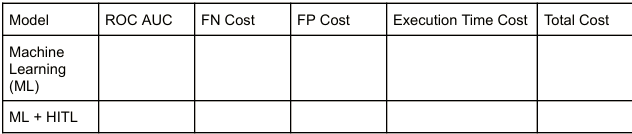
    - Has the model improved significantly in fraud detection?
    - How much additional time does the human annotation process introduce?
    - Does the increase in fraud detection performance justify the additional cost of human intervention? Assuming the cost of
execution time is $0.01 per second

In [16]:
def eval_transaction_model(
    y_true: pd.Series,
    y_pred: pd.Series,
    y_pred_proba: pd.Series,
    trx_amt: pd.Series,
) -> dict[str, float]:
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    is_fn = (y_pred == 0) & (y_true == 1)
    is_fp = (y_pred == 1) & (y_true == 0)
    fn_cost = (is_fn * trx_amt).sum()
    fp_cost = (is_fp * trx_amt).sum()

    return {
        'roc_auc': roc_auc,
        'fn_cost': fn_cost,
        'fp_cost': fp_cost,
    }

In [17]:
transaction_model_result_dict = {
    'ML': eval_transaction_model(
        df_trx_exp['Is Fraudulent'],
        df_trx_exp['y_pred'],
        df_trx_exp['y_pred_proba'],
        df_trx_exp['Transaction Amount']
    ),
    'ML+HITL': eval_transaction_model(
        df_trx_exp['Is Fraudulent'],
        df_trx_exp['y_pred_exp'],
        df_trx_exp['y_pred_proba_exp'],
        df_trx_exp['Transaction Amount']
    )
}

In [18]:
transaction_model_result = pd.DataFrame(transaction_model_result_dict).T
transaction_model_result

,roc_auc,fn_cost,fp_cost
ML,0.784595,66660.13,11939.79
ML+HITL,0.785229,55921.77,11939.79


In [19]:
transaction_model_result['exec_time'] = 0.00012 * len(df_trx_exp)
transaction_model_result.loc['ML+HITL', 'exec_time'] += addl_exec_time
transaction_model_result

,roc_auc,fn_cost,fp_cost,exec_time
ML,0.784595,66660.13,11939.79,0.567240
ML+HITL,0.785229,55921.77,11939.79,0.577348


In [20]:
transaction_model_result['exec_time_cost'] = transaction_model_result['exec_time'] * 0.01
transaction_model_result['total_cost'] = (
    transaction_model_result['fn_cost'] +
    transaction_model_result['fp_cost'] +
    transaction_model_result['exec_time_cost']
)
transaction_model_result

,roc_auc,fn_cost,fp_cost,exec_time,exec_time_cost,total_cost
ML,0.784595,66660.13,11939.79,0.567240,0.005672,78599.925672
ML+HITL,0.785229,55921.77,11939.79,0.577348,0.005773,67861.565773


How much additional time? Answer:

In [21]:
addl_exec_time

0.010107755661010742

Total cost reduction? Answer:

In [22]:
transaction_model_result.loc['ML+HITL', 'total_cost'] / transaction_model_result.loc['ML', 'total_cost'] - 1

-0.136620484142432

To answer the questions:

- Has the model improved significantly in fraud detection? Answer: not significantly. The ROC AUC score only increased marginally, from 78.46% to 78.52%.
- How much additional time does the human annotation process introduce? Answer: around 0.01 seconds (for all observations that require expert reviews; see variable `addl_exec_time`).
- Does the increase in fraud detection performance justify the additional cost of human intervention? Answer: yes. Since the additional execution time is so minuscule, the total cost is actually reduced by ~13.7% when we introduced expert reviews.

# Case 2

Data: bank_data.csv

- You are a data scientist working in the fraud detection unit of a bank.
- Your task is to develop a robust fraud detection system using machine learning
and incorporating features from social network analysis (SNA).
- The bank has provided you with a synthetic dataset called BankSim, which
simulates real-world banking transactions based on aggregated data from a bank
in Spain.
- You need a better approach to identify hidden fraud patterns and improve your
model's performance. Since fraudsters often collaborate in structured ways, you
decide to model transactions as a network where:
    - Customers (nodes) are linked to merchants (nodes) based on
transactions.
    - Edges (connections) represent transactions between customers and merchants.
    - Some transactions are labeled as fraudulent, giving insight into fraudulent behavior.
- By analyzing these relationships, you aim to uncover hidden fraud patterns that
traditional methods may miss.

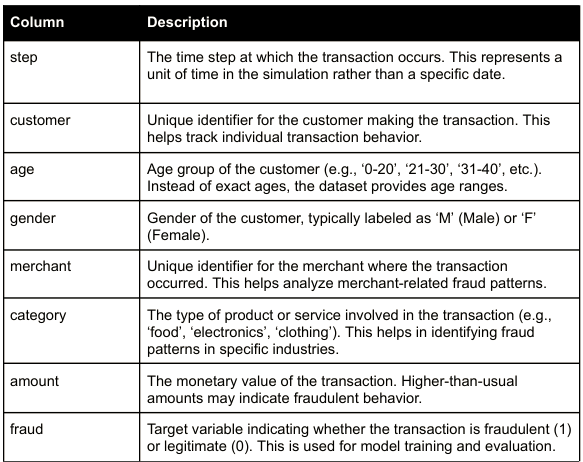

## 1. Type of fraud in network

- Explain the kind of fraud activities that could be found on the banking transaction in the data. e.g. Account Takeover (ATO) Fraud, etc.
- Identify common fraud patterns in network structures.
    - Some customers have a high number of fraudulent transactions
across multiple merchants. Find those high-risk customers by
identifying the top three customers who are connected to the
highest number of fraud cases.
    - Top three merchants that are frequently connected to fraudulent
customers (customers whose transactions are all fraud). They
might collaborate to process fraudulent transactions, either by
creating fake purchases or inflating transaction amounts.
- We can find the list of customers and merchants that we could then deny
all the transactions and add them into the blacklist. Find the list of
customers and merchants whose transactions are all fraudulent.

In [23]:
df_bank = pd.read_csv('./data/bank_data.csv')
print(df_bank.shape)
df_bank.head()

(19966, 8)


,step,customer,age,gender,merchant,category,amount,fraud
0,86,C1372889664,5,F,M1823072687,es_transportation,3.13,0
1,26,C377075708,2,M,M348934600,es_transportation,27.11,0
2,39,C1871594117,1,M,M1823072687,es_transportation,27.32,0
3,176,C730142143,4,F,M348934600,es_transportation,37.87,0
4,155,C1385354747,4,M,M1823072687,es_transportation,32.33,0


### Common fraud activities in banking transaction

Below are some fraud activities that are common in banking transactions:

- Account takeover (ATO): the attacker gains access to the victim's bank account and do the transactions there. One way the attacker can gain such access is by social engineering, or gaining the access credentials from data breaches.
- Identity theft: the attacker impersonates the victim's identity to make transactions, such as applying for credit, file taxes, or get medical services. The attacker may be able to do this if they gain access to private information like social security number. These acts may damage the victim's credit score and reputation.
- First-party fraud: this fraud occurs when someone make expensive purchase and then falsely dispute the purchase as fraudulent. In this attack, the victim is the financial institution, not another person.
- Online account opening fraud: this fraud occurs when someone opens up new accounts by using stolen or fabricated information. The attacker may then use these accounts to make fraudulent transactions.

### High-risk customers

Below are the top three customers that have highest number of fraud cases:

In [24]:
df_bank.groupby('customer')['fraud'].sum().sort_values().tail(3)

customer
C245117318     6
C1275518867    6
C1350963410    8
Name: fraud, dtype: int64

### High-risk merchants

Below are top three merchants that have highest number of fraud cases:

In [25]:
df_bank.groupby('merchant')['fraud'].sum().sort_values().tail(3)

merchant
M732195782    20
M980657600    48
M480139044    49
Name: fraud, dtype: int64

### Customers and merchants with all fraudulent transactions

Let's first calculate the probability of fraud for each merchant & customer:

In [26]:
merchant_fraud_probs = df_bank.groupby('merchant')['fraud'].mean()
cust_fraud_probs = df_bank.groupby('customer')['fraud'].mean()

Below are all merchants with only fraudulent transactions:

In [27]:
merchant_fraud_probs[merchant_fraud_probs == 1]

merchant
M1294758098    1.0
M1353266412    1.0
M1873032707    1.0
M3697346       1.0
M732195782     1.0
Name: fraud, dtype: float64

Notice that merchant "M732195782" also appeared in the previous answer.

Below are all customers with only fraudulent transactions:

In [28]:
cust_fraud_probs[cust_fraud_probs == 1]

customer
C1233811793    1.0
C1289997724    1.0
C1338125837    1.0
C1501096176    1.0
C150891114     1.0
C1560904250    1.0
C1562081159    1.0
C1572610482    1.0
C1685492470    1.0
C1728122351    1.0
C1747786179    1.0
C1803182614    1.0
C1817318774    1.0
C1903013338    1.0
C1947400039    1.0
C2004941826    1.0
C204205576     1.0
C2060410910    1.0
C2078688167    1.0
C2105324799    1.0
C2113737065    1.0
C211657450     1.0
C2126657609    1.0
C2138532527    1.0
C431496464     1.0
C483912131     1.0
C60324613      1.0
C617723960     1.0
C644541754     1.0
C706956926     1.0
C751887992     1.0
C903333805     1.0
C910454738     1.0
C932908444     1.0
Name: fraud, dtype: float64

## 2. Network based features

- Compute network-based features for each customer and
merchant:
    - Degree Centrality: Number of direct connections to a node (merchant or customer). For example, the degree centrality of customer C is 3, where the customer is connected to 3 merchants. The degree centrality of merchant A is 2, where the merchant is connected to 2 customers.

      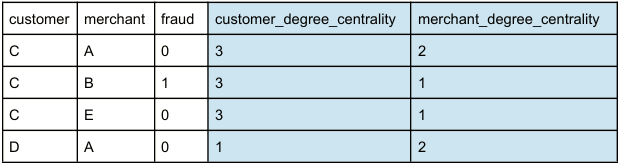

    - Fraud Proximity Score: Fraction of fraud cases among customer and merchant. Example: Customer C involved in 1 fraud cases over 3 transactions, so the proximity score is ⅓=0.333.
 
      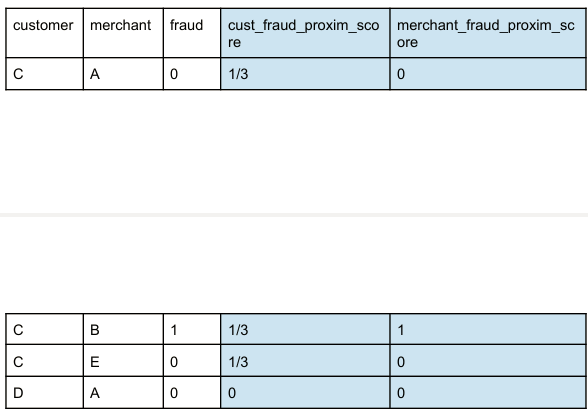
 
    - Average Transaction Value: Average monetary value of transactions in customer and merchant. Example:
 
      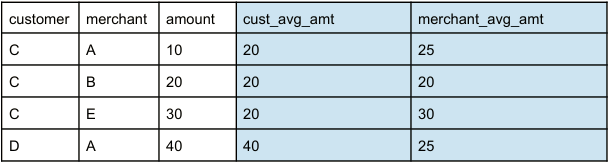
 
- Store these six features for model training.

### 2.1 Degree centrality

Below I will use `.transform` operation to project back the groupby calculations to the original data.

In [29]:
customer_degree_centrality = df_bank.groupby('customer')['customer'].transform('nunique')

In [30]:
merchant_degree_centrality = df_bank.groupby('merchant')['merchant'].transform('nunique')

Let's see the data:

In [31]:
customer_degree_centrality

0        1
1        1
2        1
3        1
4        1
        ..
19961    1
19962    1
19963    1
19964    1
19965    1
Name: customer, Length: 19966, dtype: int64

In [32]:
merchant_degree_centrality

0        1
1        1
2        1
3        1
4        1
        ..
19961    1
19962    1
19963    1
19964    1
19965    1
Name: merchant, Length: 19966, dtype: int64

As you can see, the series' length is equal to the original dataframe.

### 2.1 Fraud proximity score

In [33]:
merchant_fraud_score = df_bank.groupby('merchant')['fraud'].mean()
cust_fraud_score = df_bank.groupby('customer')['fraud'].mean()

### 2.2 Avg trx amt

In [34]:
merchant_avg_amt = df_bank.groupby('merchant')['amount'].transform('mean')
cust_avg_amt = df_bank.groupby('customer')['amount'].transform('mean')

## 3. Build model


- Train a fraud detection model using traditional features (e.g., transaction
details) and network-based features.
- Use logistic regression and decision tree to build the model
- Optimize hyperparameters (e.g., decision tree depth, regularization in
logistic regression).
- Choose the best model and evaluate model performance using
ROC-AUC.

### Data preparation

In [35]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

def fit_ohe(df: pd.DataFrame, cat_cols: list[str]) -> OneHotEncoder:
    '''
    Fit one-hot encoder for the categorical columns

    Parameters
    ----------
    df: pd.DataFrame
    cat_cols: list of str
        Name of categorical columns

    Returns
    -------
    OneHotEncoder object
    '''
    ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
    ohe.fit(df[cat_cols])
    return ohe

def transform_ohe(df: pd.DataFrame, ohe: OneHotEncoder) -> pd.DataFrame:
    '''
    Transform the categorical columns using one-hot encoder

    Parameters
    ----------
    df: pd.DataFrame
    ohe: fitted OneHotEncoder object

    Returns
    -------
    pd.DataFrame
    '''
    cat_cols = ohe.feature_names_in_
    df = df.copy()
    df_ohe = pd.DataFrame(
        ohe.transform(df[cat_cols]),
        index=df.index,
        columns=ohe.get_feature_names_out()
    )
    df = pd.concat([df, df_ohe], axis=1)
    df = df.drop(cat_cols, axis=1)
    return df
def fit_scaler(df: pd.DataFrame) -> StandardScaler:
    '''
    Fit a standard scaler on all columns

    Parameters
    ----------
    df: pd.DataFrame

    Returns
    -------
    StandardScaler object
    '''
    scaler = StandardScaler()
    scaler.fit(df)
    return scaler

def transform_scaler(df: pd.DataFrame, scaler: StandardScaler) -> pd.DataFrame:
    '''
    Transform data using a standard scaler

    Parameters
    ----------
    df: pd.DataFrame
    scaler: fitted StandardScaler object

    Returns
    -------
    pd.DataFrame
    '''
    return pd.DataFrame(
        scaler.transform(df),
        index=df.index,
        columns=df.columns
    )


In [36]:
X_bank = df_bank.drop(['fraud', 'customer', 'merchant'], axis=1)
y_bank = df_bank['fraud']

bank_ohe = fit_ohe(X_bank, cat_cols=['gender', 'category'])
X_bank_ohe = transform_ohe(
    X_bank,
    bank_ohe
)
bank_scaler = fit_scaler(X_bank_ohe)
X_bank_clean = transform_scaler(X_bank_ohe, bank_scaler)
X_bank_clean.head()

,step,age,amount,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,...,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
0,-0.179586,1.509244,-0.347870,0.906210,-0.905111,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.060577,-0.053976,-0.102603,-0.02832,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618
1,-1.356202,-0.757006,-0.105115,-1.103497,1.104837,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.060577,-0.053976,-0.102603,-0.02832,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618
2,-1.101268,-1.512422,-0.102989,-1.103497,1.104837,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.060577,-0.053976,-0.102603,-0.02832,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618
3,1.585337,0.753828,0.003811,0.906210,-0.905111,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.060577,-0.053976,-0.102603,-0.02832,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618
4,1.173522,0.753828,-0.052272,-1.103497,1.104837,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.060577,-0.053976,-0.102603,-0.02832,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618


Below I'll prepare data containing network-based data.

**Note**: I will not include fraud proximity score, because doing it will pollute the data with the y-variable. (The model becomes invalid.)

In [37]:
X_bank_network = X_bank_clean.copy()
X_bank_network['customer_degree_centrality'] = customer_degree_centrality
X_bank_network['merchant_degree_centrality'] = merchant_degree_centrality
X_bank_network['merchant_avg_amt'] = merchant_avg_amt
X_bank_network['cust_avg_amt'] = cust_avg_amt
X_bank_network.head()

,step,age,amount,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,...,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,customer_degree_centrality,merchant_degree_centrality,merchant_avg_amt,cust_avg_amt
0,-0.179586,1.509244,-0.347870,0.906210,-0.905111,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618,1,1,27.124874,11.713333
1,-1.356202,-0.757006,-0.105115,-1.103497,1.104837,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618,1,1,26.723216,41.082857
2,-1.101268,-1.512422,-0.102989,-1.103497,1.104837,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618,1,1,27.124874,24.384000
3,1.585337,0.753828,0.003811,0.906210,-0.905111,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618,1,1,26.723216,36.246000
4,1.173522,0.753828,-0.052272,-1.103497,1.104837,-0.024523,-0.107953,-0.042501,-0.105796,-0.210479,...,-0.038792,-0.082815,-0.060993,0.416621,-0.033213,-0.157618,1,1,27.124874,24.160000


### Splitting the data

In [38]:
from sklearn.model_selection import train_test_split

X_bank_train, X_bank_test, y_bank_train, y_bank_test = train_test_split(X_bank_clean, y_bank, test_size=0.4, random_state=12)

In [39]:
X_bank_network_train = X_bank_network.loc[X_bank_train.index]
X_bank_network_test = X_bank_network.loc[X_bank_test.index]

### Building the model (without networks)

In [40]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from datetime import datetime

def fit_eval_cv(
    cv_obj: GridSearchCV,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series
):
    '''
    Fit and evaluate the given cv model.
    Will print out the train/test scores.
    Returns dictionary containing:
    - training_score
    - test_score
    - best_model
    - best_params
    '''
    start_time = datetime.now()
    cv_obj.fit(X_train, y_train)
    elapsed = datetime.now() - start_time
    print(f'Elapsed: {elapsed}')

    train_score = cv_obj.score(X_train, y_train)
    test_score = cv_obj.score(X_test, y_test)
    best_params = cv_obj.best_params_

    print(f'Train score: {train_score:.4f}')
    print(f'Valid score: {test_score:.4f}')
    print(f'Best Params: {best_params}')
    return {
        'train_score': train_score,
        'test_score': test_score,
        'best_model': cv_obj.best_estimator_,
        'best_params': best_params,
    }

In [41]:
gs_config = dict(
    cv = 10,
    scoring = 'roc_auc',
)
gs_input = dict(
    X_train = X_bank_train,
    y_train = y_bank_train,
    X_test = X_bank_test,
    y_test = y_bank_test,
)
gs_results = {}

In [42]:
gs_results['LogisticRegression'] = fit_eval_cv(
    GridSearchCV(
        estimator = LogisticRegression(solver='liblinear', random_state=42, class_weight=None, penalty='l1'),
        param_grid = {
            'C': np.logspace(-5, 5, 10),
        },
        **gs_config,
    ),
    **gs_input
)

C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Elapsed: 0:27:03.376991
Train score: 0.9928
Valid score: 0.9904
Best Params: {'C': 0.2782559402207126}


In [43]:
gs_results['DecisionTree'] = fit_eval_cv(
    GridSearchCV(
        estimator = DecisionTreeClassifier(random_state=42),
        param_grid = {
            'max_depth': [2, 5, 10, 30, None],
            'min_samples_split': [2, 3, 4, 5, 10, 25, 50],
            'min_samples_leaf': [2, 3, 4, 5, 10, 20],
        },
         **gs_config,
    ),
    **gs_input
)

Elapsed: 0:01:10.003377
Train score: 0.9618
Valid score: 0.9294
Best Params: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 50}


### Building the model (with networks)

In [44]:
gs_input_network = dict(
    X_train = X_bank_network_train,
    y_train = y_bank_train,
    X_test = X_bank_network_test,
    y_test = y_bank_test,
)
gs_results_network = {}

In [45]:
gs_results_network['LogisticRegression'] = fit_eval_cv(
    GridSearchCV(
        estimator = LogisticRegression(solver='liblinear', random_state=42, class_weight=None, penalty='l1'),
        param_grid = {
            'C': np.logspace(-5, 5, 10),
        },
        **gs_config,
    ),
    **gs_input_network
)

C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\abang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Elapsed: 0:28:02.118883
Train score: 0.9957
Valid score: 0.9939
Best Params: {'C': 0.2782559402207126}


In [46]:
gs_results_network['DecisionTree'] = fit_eval_cv(
    GridSearchCV(
        estimator = DecisionTreeClassifier(random_state=42),
        param_grid = {
            'max_depth': [2, 5, 10, 30, None],
            'min_samples_split': [2, 3, 4, 5, 10, 25, 50],
            'min_samples_leaf': [2, 3, 4, 5, 10, 20],
        },
         **gs_config,
    ),
    **gs_input_network
)

Elapsed: 0:01:42.458099
Train score: 0.9673
Valid score: 0.9073
Best Params: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}


In [49]:
gs_results = pd.DataFrame(gs_results).T
gs_results

,train_score,test_score,best_model,best_params
LogisticRegression,0.992761,0.990395,"LogisticRegression(C=0.2782559402207126, penal...",{'C': 0.2782559402207126}
DecisionTree,0.961794,0.929366,"DecisionTreeClassifier(max_depth=5, min_sample...","{'max_depth': 5, 'min_samples_leaf': 20, 'min_..."


In [50]:
gs_results_network = pd.DataFrame(gs_results_network).T
gs_results_network

,train_score,test_score,best_model,best_params
LogisticRegression,0.995662,0.993894,"LogisticRegression(C=0.2782559402207126, penal...",{'C': 0.2782559402207126}
DecisionTree,0.967264,0.907271,"DecisionTreeClassifier(max_depth=5, min_sample...","{'max_depth': 5, 'min_samples_leaf': 20, 'min_..."


## 4. Evaluation

- Train the best model obtained from the hyperparameter in the previous
question using traditional features only.
- Evaluate the performance of the model using ROC-AUC. Compare the
performance and summarize in the table

    |Feature|ROC AUC|
    |-|-|
    |Traditional| |
    |Traditional+Network| |

- Do additional network-based features improve fraud detection
performance?

In [55]:
best_result_basic = gs_results.iloc[gs_results['test_score'].argmax()]
best_result_network = gs_results_network.iloc[gs_results_network['test_score'].argmax()]

In [58]:
print('Best model (basic):', best_result_basic.name)
print('Best model (network):', best_result_network.name)

Best model (basic): LogisticRegression
Best model (network): LogisticRegression


Final comparison:

In [62]:
pd.DataFrame({
    'Traditional': {'ROC AUC': best_result_basic['test_score']},
    'Traditional+Network': {'ROC AUC': best_result_network['test_score']},
}).T

,ROC AUC
Traditional,0.990395
Traditional+Network,0.993894


Based on the above analysis, we can conclude that using network-based features improve the model ROC AUC from 99.0395% to 99.3894%.